# Import Packages

In [1]:
import sys
import os
import shutil
import librosa
import glob
import tqdm
import json
import ast
import random

from librosa import display as ld

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K

!pip install git+https://github.com/AI-Guru/ngdlm.git
tf.compat.v1.disable_eager_execution()

from sklearn.preprocessing import StandardScaler
from sklearn.externals.joblib import load, dump
#sys.modules['sklearn.externals.joblib'] = joblib

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from IPython import display as ipd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from configparser import ConfigParser

  Cloning https://github.com/AI-Guru/ngdlm.git to /tmp/pip-req-build-b7n2ap9b
  Running command git clone -q https://github.com/AI-Guru/ngdlm.git /tmp/pip-req-build-b7n2ap9b
  Created wheel for ngdlm: filename=ngdlm-0.0.3-py2.py3-none-any.whl size=32027 sha256=e824f88771659993e91e6a116ef9e05fcd02b88d559a38ecb78978a44ed50936
  Stored in directory: /tmp/pip-ephem-wheel-cache-5eiimptn/wheels/93/06/27/e156acb49f475c364c3c9fa4ad4ab7bfa38808bff5bf9c4647
Successfully built ngdlm


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Mount Google Drive
#### 1. First mount

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/sound-of-failure

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/sound-of-failure


# Import Own Modules

In [3]:
sys.path += ['src/00_utils', 'src/01_data_processing', 'src/02_modelling', 'src/03_modell_evaluation', 'src/04_visualization']

import spectrogram as spec
import train_test_split as splt
import train_model_autoencoder as train
import naming
import eval_model_autoencoder as eval
import plotly_visualization as plotly_viz

# Global constants

In [4]:
%run /gdrive/MyDrive/sound-of-failure/src/00_utils/make_conf_base.py -raw '/gdrive/MyDrive/mimii_baseline/dataset' -prj '/gdrive/MyDrive'
%run /gdrive/MyDrive/sound-of-failure/src/00_utils/make_conf_AE.py -prj '/gdrive/MyDrive' -ae lstmAE -noise 6dB -type valve -id id_00 -mel 16 -fft 1024 -hop 512 -dim 32 -s 8

##### Load base configuration.

In [5]:
base_conf = train.read_config('conf/conf_base.ini')

##### Select an autoencoder config file by specifying the run ID.

In [6]:
naming.show_run_ids()

,run_id,conf,scaler,model,comment
0,VAE_6dB_valve_id_00_1,True,True,True,
1,VAE_6dB_valve_id_00_final,True,True,True,
2,lstmAE_6dB_valve_id_00,True,True,True,Default run ID. Archive run to prevent overwri...
3,lstmAE_6dB_valve_id_00_1,True,True,True,
4,lstmAE_6dB_valve_id_02_1,True,True,True,


In [7]:
run_id = 'VAE_6dB_valve_id_00_final'

conf_path = naming.get_conf_path(run_id)
param_conf = train.read_config(conf_path)

#### Read the parameters directly from the config files

Question : Should the reading of config files be done within notebooks or the source script should directly read from them?

In [8]:
# Directories
RAW_DATA_DIR = base_conf['directories']['raw_data_dir']
BASE_DIR = base_conf['directories']['base_dir']


# Mel spectrograms
N_MELS = param_conf.getint('melspec', 'n_mels')
N_FFT = param_conf.getint('melspec', 'n_fft')
HOP_LENGTH = param_conf.getint('melspec', 'hop_length')
POWER = param_conf.getfloat('melspec', 'power')
WINDOW = param_conf.get('melspec', 'window')


# Subsampling
DIM = param_conf.getint('melspec', 'dim')
STEP = param_conf.getint('melspec', 'step')


# Scaler and cost function
SCALER_TYPE = param_conf.get('model', 'scaler')
LOSS = param_conf.get('model', 'loss')


# Optimizer
OPTIMIZER = param_conf.get('model', 'optimizer')
EPOCHS = param_conf.getint('model', 'epochs')
BATCH_SIZE = param_conf.getint('model', 'batch_size')
VALIDATION_SPLIT = param_conf.getfloat('model', 'val_split')
SHUFFLE = param_conf.getboolean('model', 'shuffle')


# Autoencoder
MODEL_NAME = param_conf.get('autoencoder', 'model_name')

if MODEL_NAME == 'lstmAE':
    NUM_NODES = json.loads(param_conf.get('autoencoder', 'num_nodes'))
    INPUT_SHAPE = (param_conf.getint('melspec', 'dim'),
                   param_conf.getint('melspec', 'n_mels'))
elif MODEL_NAME in ['AE', 'VAE']:
    LATENT_DIM = param_conf.getint('autoencoder', 'latentdim')
    NUM_NODES = json.loads(param_conf.get('autoencoder', 'num_nodes'))
    NUM_KERNEL = json.loads(param_conf.get('autoencoder', 'num_kernel'))
    NUM_STRIDES = param_conf.get('autoencoder', 'num_strides')
    NUM_STRIDES = list(ast.literal_eval(NUM_STRIDES))
    INPUT_SHAPE = (param_conf.getint('melspec', 'dim'),
                   param_conf.getint('melspec', 'n_mels'),
                   1)
else:
    print('Invalid model name.')


# Data
DB = param_conf.get('data', 'noise')
MACHINE_TYPE = param_conf.get('data', 'machine')
MACHINE_ID = param_conf.get('data', 'machine_id')

# Execute preprocessing steps
#### 1. Generate unscaled mel spectrograms (~ 5 minutes)

In [7]:
spec.make_mel_dirs(BASE_DIR, DB, MACHINE_TYPE, MACHINE_ID)

spec.make_mels(RAW_DATA_DIR, BASE_DIR, 
               DB, MACHINE_TYPE, MACHINE_ID, 
               N_MELS, N_FFT, HOP_LENGTH, POWER, WINDOW, overwrite=False)

Directory already exists: /gdrive/MyDrive/sound-of-failure/data/mel_spectrograms/6dB/valve/id_00/normal
Directory already exists: /gdrive/MyDrive/sound-of-failure/data/mel_spectrograms/6dB/valve/id_00/abnormal


  0%|          | 0/991 [00:00<?, ?it/s]

Generate normal spectrograms and save to /gdrive/MyDrive/sound-of-failure/data/mel_spectrograms/6dB/valve/id_00/normal.


  0%|          | 0/119 [00:00<?, ?it/s]

Created 0 new spectrograms, kept 991 existing spectrograms.
Generate abnormal spectrograms and save to /gdrive/MyDrive/sound-of-failure/data/mel_spectrograms/6dB/valve/id_00/abnormal.


100%|██████████| 119/119 [00:03<00:00, 31.00it/s]

Created 0 new spectrograms, kept 119 existing spectrograms.


#### 2. Separate train and test files

In [9]:
train_files, train_labels, test_files, test_labels = splt.make_train_test_split(BASE_DIR, 
                                                                                DB, MACHINE_TYPE, MACHINE_ID, 
                                                                                random_seed=1)

#### 3. Load scaler

In [10]:
scaler_path = naming.get_scaler_path(run_id)
scaler = spec.fit_and_save_scaler(SCALER_TYPE, train_files, scaler_path, overwrite=False)

Loading existing scaler models/VAE_6dB_valve_id_00_final.gz.


# Model evaluation 
#### Standard evaluation

In [11]:
model_path = naming.get_model_path(run_id)
model = train.load_saved_model(model_path)

In [11]:
# Reconstruction loss for test and train spectrograms
if MODEL_NAME == 'lstmAE':
  as_images = False
else:
  as_images = True


reco_loss_test = eval.reco_loss(model=model, 
                                scaler=scaler,
                                dim=DIM,
                                step=STEP,
                                test_files=test_files, 
                                as_images=as_images)

reco_loss_train = eval.reco_loss(model=model, 
                                 scaler=scaler,
                                 dim=DIM,
                                 step=STEP,
                                 test_files=train_files, 
                                 as_images=as_images)

  0%|          | 0/238 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
100%|██████████| 872/872 [08:00<00:00,  1.81it/s]


Roc AUC score=0.971259091872043


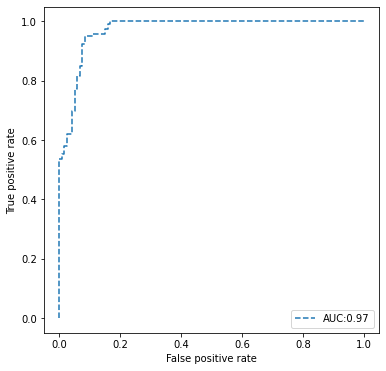

In [12]:
eval.plot_roc_curve(test_labels, reco_loss_test)

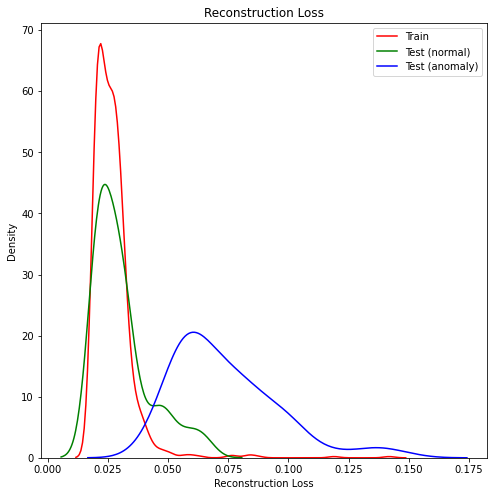

In [13]:
eval.plot_losses(y_true=test_labels,
                 y_pred=reco_loss_test,
                 y_train=reco_loss_train,
                 title="Reconstruction Loss",
                 xlabel='Reconstruction Loss')

#### Additional evaluation

In [12]:
mel_file = spec.get_normal_mel_files(BASE_DIR, DB, MACHINE_TYPE, MACHINE_ID)[0]
model=model
scaler=scaler
dim=DIM
step=STEP
thresh_range = np.arange(0.0,0.2,0.01)

plotly_viz.make_eval_visualisation(mel_file, 
                                  model, 
                                  scaler, 
                                  dim, 
                                  step, 
                                  thresh_range, 
                                  active_step=1, 
                                  as_images=True)

Output hidden; open in https://colab.research.google.com to view.

In [13]:
mel_file = spec.get_abnormal_mel_files(BASE_DIR, DB, MACHINE_TYPE, MACHINE_ID)[0]
model=model
scaler=scaler
dim=DIM
step=STEP
thresh_range = np.arange(0.0,0.2,0.01)

plotly_viz.make_eval_visualisation(mel_file, 
                                  model, 
                                  scaler, 
                                  dim, 
                                  step, 
                                  thresh_range, 
                                  active_step=1, 
                                  as_images=True)

Output hidden; open in https://colab.research.google.com to view.